In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import pandas as pd
import ast

### helper functions

In [2]:

gb = []
data_path = './dataset-dev/plates_png/'
for i in os.listdir(data_path):
    if i.__contains__('GB'):
        
        gb.append(i)


In [3]:
def calculate_area(contour):
    x,y,w,h = cv2.boundingRect(contour)
    return w*h

In [4]:
def are_close(a, b) -> bool:
    """
    Compares two integers and checks if they are within 10% of each other.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        bool: True if the integers are within 10% of each other, False otherwise.
    """
    if a == 0 or b == 0:
        # Handle edge case where one or both integers are zero
        return a == b

    # Calculate the difference as a percentage of the larger value
    difference_percentage = abs(a - b) / max(abs(a), abs(b))
    return difference_percentage <= 0.3

### First phase segmentation

In [1]:
def process(img,kernel_size=5,iters=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, 50, 150, apertureSize=5,L2gradient=False)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations=iters)

    return img_dilate

#first phase of segmentation to remove outer border present in images
def perfect_phase_1(img_path):
    img = cv2.imread(img_path)
    img_copy = np.copy(img)
    
    processed_img = process(img_copy)
    
    contours, _ = cv2.findContours(processed_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    filter_contours = [ct for ct in contours if cv2.contourArea(ct) > 5000] #filter out small contours
    areas = []
    
    
    for ct in filter_contours:
        x, y, w, h = cv2.boundingRect(ct)
        #cv2.rectangle(img_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
        #cv2.putText(img_copy, str(cv2.contourArea(ct)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        areas.append(w * h)
        
    #get the two biggest contours
    top2 = []
    for i in range(3):
        largest_index = areas.index(max(areas))
        #print(max(areas))
        largest_contour = filter_contours[largest_index]    
        top2.append(largest_contour)
        
        # Remove the selected contour from the lists
        del areas[largest_index]
        del filter_contours[largest_index]
    
    
    #big = cv2.contourArea(top2[0])
    #small = cv2.contourArea(top2[1]) + cv2.contourArea(top2[2])
    big = calculate_area(top2[0])
    small = calculate_area(top2[1]) + calculate_area(top2[2]) 
    l = [big,small]
    
    #check_2_plates =min(l)/max(l)  
    
    ratio = 0
    if cv2.contourArea(top2[1]) >= cv2.contourArea(top2[2]):
        ratio = cv2.contourArea(top2[2]) / cv2.contourArea(top2[1])
    else:
        ratio = cv2.contourArea(top2[1]) / cv2.contourArea(top2[2])
    
    #print('check de 2 planches',check_2_plates)
    #print('check une planche',calculate_area(top2[1])/big)
    #print('ratio',ratio)
    rect0 = cv2.boundingRect(top2[0])
    rect1 = cv2.boundingRect(top2[1])
    rect2 = cv2.boundingRect(top2[2])
    
    cont2 = 0
    for i in range(4):
        #print(rect1[i],rect2[i])
        if(are_close(rect0[i],rect1[i])):
            cont2+=1
    check_2_plates = cont2>=2
    #put the area in text on the image
    
        
    #print('width une planche',are_close_within_10_percent(w0,w1))
    #print('x une planche',are_close_within_10_percent(x0,x1))
    #print('x 2 planches',are_close_within_10_percent(x1,x2))
    #print('width 2 planches',are_close_within_10_percent(w1,w2))
    #print('shape', img_copy.shape)
    cont = 0
    for i in range(4):
        #print(rect0[i],rect1[i])
        if(are_close(rect0[i],rect1[i])):
            cont+=1
            
    #and ( rect1[0] != 0 and rect1[1] != 0)
    cond = cont>=2 and (rect0[0] != 0 and rect0[1] != 0 ) 
    
    #print('cond',cond)
    #print([cv2.contourArea(x)   for x in top2])
    
    if calculate_area(top2[1])/big >0.7 and cond:
        #print('planche complete')
        top2 = [top2[1]]
    elif check_2_plates> 0.8 and ratio > 0.7:
        top2 = top2[1:]
        #print('2 planches')
       
    else:
        #print('skip')
        return img_copy, [], []
        
    '''
    if small/big >0.9 and ratio > 0.7:

        top2 = top2[1:]
    else:
        top2 = [top2[1]]'''

    color =[255,255,255]

    res = []

    for ct in top2:
        cop = np.copy(img)
        stencil = np.zeros(img.shape).astype(np.uint8)

        epsilon = 0.01 * cv2.arcLength(ct, True)
        approx = cv2.approxPolyDP(ct, epsilon, True)
        hull = cv2.convexHull(approx)
        if len(hull) < 4 or len(hull)>=6 :
            continue
        cv2.drawContours(img_copy, [hull], -1, (255, 0, 0), 4)
        
        
        cv2.fillPoly(stencil, pts =[hull], color=color)

        res.append(cv2.bitwise_or(cop, ~stencil))

    return img_copy, top2, res
    

In [6]:


def is_contour_inside(contour1, contour2):
    x1, y1, w1, h1 = cv2.boundingRect(contour1)  # inside
    x2, y2, w2, h2 = cv2.boundingRect(contour2)  # outside
    if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
        return True

def bounding_box_to_contour(box):
    x, y, w, h = box
    contour = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ])
    return contour

### Second phase segmentation

In [2]:
def second_phase(img_first_phase):
    img_copy = np.copy(img_first_phase)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(process(img_copy,kernel_size=9,iters=1), connectivity=8, ltype=cv2.CV_32S)
    contours = []
    #area = img_copy.shape[0] * img_copy.shape[1]
    for i in range(1, num_labels):
        x, y, w, h, _ = stats[i]
        box = (x, y, w, h)
        contour = bounding_box_to_contour(box)
        contours.append(contour)
        
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 10000]
    # get rid of small contours
    sorted_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)
    
    draw_contours = []
    for idx,contour in enumerate(sorted_contours):
        #print(cv2.contourArea(contour))
        if idx == 0:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
            draw_contours.append((x, y, w, h))
            #rect = cv2.minAreaRect(contour)
            #box = cv2.boxPoints(rect)
            #box = np.int0(box)
            #cv2.drawContours(img_copy,[box],0,(0,0,255),2) '''  
        else:
            #x, y, w, h = cv2.boundingRect(contour)
            res = False
            for i in range(idx):
                if is_contour_inside(contour, sorted_contours[i]):
                    res = True
                    break
            if not res: #the contour is not inside any of the previous contours
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
                #rect = cv2.minAreaRect(contour)
                #box = cv2.boxPoints(rect)
                #box = np.int0(box)
                #cv2.drawContours(img_copy,[box],0,(0,0,255),2)
                draw_contours.append((x, y, w, h))
    return img_copy, sorted_contours,draw_contours

### Test

In [10]:

img,_,res  = perfect_phase_1(data_path+"GB.184049.A-004.png")
cv2.imshow("seg", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
for img in res:
    seg,_,contours = second_phase(img)
    cv2.imshow("seg", seg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    


In [9]:
data = pd.read_csv('data_dl.csv') ## load annotated data of label-studio
data

,image,label
0,GB.112704.A-011.png,"(439, 912, 1645, 1502)"
1,GB.220420.A-010.png,"(491, 726, 1554, 1761)"
2,GB.272628.A-015.png,"(190, 1824, 2046, 1191)"
3,GB.272628.A-015.png,"(203, 722, 952, 1101)"
4,GB.191506686.A-011.png,"(0, 429, 1547, 1037)"
...,...,...
1197,GB.561274.A-009.png,"(1038, 1795, 1089, 213)"
1198,GB.561274.A-009.png,"(1233, 1342, 877, 211)"
1199,GB.561274.A-009.png,"(609, 1541, 327, 449)"
1200,GB.561274.A-009.png,"(761, 1369, 425, 165)"


In [10]:
data['label'] = data['label'].apply(ast.literal_eval)
data

,image,label
0,GB.112704.A-011.png,"(439, 912, 1645, 1502)"
1,GB.220420.A-010.png,"(491, 726, 1554, 1761)"
2,GB.272628.A-015.png,"(190, 1824, 2046, 1191)"
3,GB.272628.A-015.png,"(203, 722, 952, 1101)"
4,GB.191506686.A-011.png,"(0, 429, 1547, 1037)"
...,...,...
1197,GB.561274.A-009.png,"(1038, 1795, 1089, 213)"
1198,GB.561274.A-009.png,"(1233, 1342, 877, 211)"
1199,GB.561274.A-009.png,"(609, 1541, 327, 449)"
1200,GB.561274.A-009.png,"(761, 1369, 425, 165)"


In [11]:
gt_names = data['image'].unique()
data_path = './dataset-dev/plates_png/'

### Apply segmentation to non skippable annotated patents

In [39]:
samples = pd.DataFrame(columns=['image','label'])
for name in gt_names:
    print(name)
    img,_ ,res= perfect_phase_1(data_path+name)

    for mask in res:
        img,_ ,contours= second_phase(mask)
        sample = {'image':name,'label':contours}
        samples = samples.append(sample,ignore_index=True)


GB.112704.A-011.png
GB.220420.A-010.png
GB.272628.A-015.png
GB.191506686.A-011.png
GB.125650.A-013.png
GB.152368.A-038.png
GB.191223716.A-012.png
GB.216640.A-004.png
GB.171939.A-005.png
GB.121298.A-007.png
GB.334584.A-060.png
GB.359612.A-007.png
GB.334584.A-048.png
GB.334584.A-049.png
GB.359612.A-006.png
GB.334584.A-061.png
GB.331224.A-006.png
GB.121298.A-012.png
GB.171939.A-010.png
GB.152368.A-011.png
GB.191417192.A-005.png
GB.216640.A-005.png
GB.191223716.A-013.png
GB.152368.A-039.png
GB.125650.A-012.png
GB.191506686.A-010.png
GB.272628.A-014.png
GB.191020675.A-004.png
GB.112704.A-010.png
GB.112704.A-012.png
GB.180631.A-004.png
GB.220420.A-007.png
GB.272628.A-016.png
GB.357609.A-003.png
GB.125650.A-010.png
GB.191500509.A-008.png
GB.191506686.A-012.png
GB.191223716.A-011.png
GB.191417192.A-007.png
GB.152368.A-013.png
GB.171939.A-006.png
GB.121298.A-010.png
GB.331224.A-004.png
GB.359612.A-005.png
GB.331224.A-005.png
GB.121298.A-011.png
GB.324544.A-003.png
GB.171939.A-007.png
GB.216640.

In [12]:
samples = pd.read_csv('results_implementation.csv')
samples

,image,label
0,GB.220420.A-010.png,"(507, 729, 1524, 1756)"
1,GB.191223716.A-012.png,"(325, 986, 787, 1396)"
2,GB.191223716.A-012.png,"(1282, 992, 511, 929)"
3,GB.171939.A-005.png,"(394, 780, 1513, 1183)"
4,GB.171939.A-005.png,"(514, 1959, 1170, 939)"
...,...,...
1066,GB.561274.A-009.png,"(763, 1372, 421, 161)"
1067,GB.561274.A-009.png,"(1071, 1531, 279, 90)"
1068,GB.561274.A-009.png,"(859, 1987, 867, 29)"
1069,GB.561274.A-009.png,"(618, 2465, 1529, 673)"


In [16]:
samples = samples.explode('label',ignore_index=True)
samples

,image,label
0,GB.220420.A-010.png,"(507, 729, 1524, 1756)"
1,GB.191223716.A-012.png,"(325, 986, 787, 1396)"
2,GB.191223716.A-012.png,"(1282, 992, 511, 929)"
3,GB.171939.A-005.png,"(394, 780, 1513, 1183)"
4,GB.171939.A-005.png,"(514, 1959, 1170, 939)"
...,...,...
1066,GB.561274.A-009.png,"(763, 1372, 421, 161)"
1067,GB.561274.A-009.png,"(1071, 1531, 279, 90)"
1068,GB.561274.A-009.png,"(859, 1987, 867, 29)"
1069,GB.561274.A-009.png,"(618, 2465, 1529, 673)"


In [13]:
samples['label'] = samples['label'].apply(ast.literal_eval)

In [14]:
setA = set(samples['image'])
setB = set(data['image'])
difference = setB.difference(setA)
len(difference)


179

In [15]:
for img in difference:
    img = cv2.imread(data_path+img)
    cv2.imshow("seg", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [54]:

samples

,image,label
0,GB.220420.A-010.png,"(507, 729, 1524, 1756)"
1,GB.191223716.A-012.png,"(325, 986, 787, 1396)"
2,GB.191223716.A-012.png,"(1282, 992, 511, 929)"
3,GB.171939.A-005.png,"(394, 780, 1513, 1183)"
4,GB.171939.A-005.png,"(514, 1959, 1170, 939)"
...,...,...
1066,GB.561274.A-009.png,"(763, 1372, 421, 161)"
1067,GB.561274.A-009.png,"(1071, 1531, 279, 90)"
1068,GB.561274.A-009.png,"(859, 1987, 867, 29)"
1069,GB.561274.A-009.png,"(618, 2465, 1529, 673)"


In [18]:
def compute_iou(rect1, rect2):
    """
    Computes the Intersection over Union (IoU) between two rectangles.
    
    Parameters:
    - rect1: Tuple (x1, y1, w1, h1) representing the first rectangle
    - rect2: Tuple (x2, y2, w2, h2) representing the second rectangle
    
    Returns:
    - IoU: The Intersection over Union (IoU) value
    """
    # Convert rectangles to (x1, y1, x2, y2)
    x1_min, y1_min, w1, h1 = rect1
    x2_min, y2_min, w2, h2 = rect2
    
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_max, y2_max = x2_min + w2, y2_min + h2

   
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection_area = inter_width * inter_height
   #print(f'intersection :{intersection_area}')


    area1 = w1 * h1
    area2 = w2 * h2


    union_area = area1 + area2 - intersection_area


    if union_area == 0:
        print('im here')  
        return 0
    iou = intersection_area / union_area
    return iou

In [24]:
def check_image(image_name,data_path='./dataset-dev/plates_png/'):
    image_path = data_path+image_name
    img = cv2.imread(image_path)
    img_copy = np.copy(img)
    
    
    df1 = data[data['image'] == image_name]
    df2 = samples[samples['image'] == image_name]
    for _,r in df1.iterrows():
        rect1 = r['label']
        x,y,w,h = rect1
        cv2.rectangle(img_copy, (x,y), (x+w, y+h), (0, 255, 0), 5)
    for _,r in df2.iterrows():
        rect2 = r['label']
        x,y,w,h = rect2
        cv2.rectangle(img_copy, (x,y), (x+w, y+h), (0, 0, 255), 5)
    return img_copy


In [ ]:
def analyze_ious(data, samples, iou_thresholds=[0.5, 0.75, 0.9]):
    iou_results = []  
    precision_recall = {t: {'precision': [], 'recall': []} for t in iou_thresholds}
    per_image_ious = []  # Average IoUs per image

    for image in samples['image'].unique():
        gt_boxes = data[data['image'] == image]['label'].tolist()
        pred_boxes = samples[samples['image'] == image]['label'].tolist()

        # Track matches
        matched_gt = set()
        matched_pred = set()
        img_ious = []  # IoUs for this image

        # Match each ground truth box to the best prediction
        for gt_idx, gt in enumerate(gt_boxes):
            max_iou = 0
            best_pred_idx = None

            for pred_idx, pred in enumerate(pred_boxes):
                if pred_idx not in matched_pred:  # Only consider unmatched predictions
                    iou = compute_iou(gt, pred)
                    if iou > max_iou:
                        max_iou = iou
                        best_pred_idx = pred_idx

            if best_pred_idx is not None and max_iou > 0.5:
                # If a match is found, mark the prediction as matched
                matched_gt.add(gt_idx)
                matched_pred.add(best_pred_idx)
                img_ious.append(max_iou)  # Record the IoU of the match
            else:
                # No match found for this GT box
                img_ious.append(0)  # Record IoU as 0 for unmatched GT box

        #Handle unmatched predictions fp
        unmatched_preds = len(pred_boxes) - len(matched_pred)
        
        #Add IoUs for this image to the global list (including zeros for unmatched GTs)
        iou_results.extend(img_ious)

        #Per-image mean IoU (include zeros for unmatched GTs)
        per_image_ious.append(np.mean(img_ious) if img_ious else 0)

        # Calculate precision and recall for each threshold
        for t in iou_thresholds:
            tp = sum(iou > t for iou in img_ious)  # True positives
            fn = len(gt_boxes) - len(matched_gt)  # False negatives
            fp = unmatched_preds  # False positives

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0

            precision_recall[t]['precision'].append(precision)
            precision_recall[t]['recall'].append(recall)

    #Combine results into mean precision/recall per threshold
    combined_precision_recall = {
        t: {
            'precision': np.mean(precision_recall[t]['precision']),
            'recall': np.mean(precision_recall[t]['recall'])
        }
        for t in iou_thresholds
    }

    return iou_results, per_image_ious, combined_precision_recall
iou_results, per_image_ious, combined_precision_recall = analyze_ious(data, samples, iou_thresholds=[0.5, 0.75, 0.9])
print(combined_precision_recall)


{0.5: {'precision': 0.7330035386069869, 'recall': 0.9423611111111111}, 0.75: {'precision': 0.7208022102418654, 'recall': 0.9271620142309798}, 0.9: {'precision': 0.6796443499029706, 'recall': 0.8726669403393541}}


In [130]:
per_image_ious

[0.9779104975016389,
 0.5259015335709368,
 0.8034990453640839,
 0.7992155250160036,
 0.6952271021021021,
 0.9718114343075414,
 0.9782369257831,
 0.8924265960375825,
 0.9780235520784353,
 0.9732752888182173,
 0.9791775430408265,
 0.9458757859309876,
 0.9222491485824129,
 0.8437999118509472,
 0.9072210089918012,
 0.9963327702006676,
 0.9952967832268554,
 0.7258543615148698,
 0.9723021823464084,
 0.9736953523056833,
 0.9818614499351604,
 0.5273879505018,
 0.9829432467173713,
 0.9735595446329979,
 0.628728442943119,
 0.9851219285328744,
 0.7356168920621109,
 0.956778373540585,
 0.9620391415442106,
 0.8962168417304611,
 0.9944100008267989,
 0.8832121216153322,
 0.9693375898092168,
 0.9440568397588975,
 0.9946162732404804,
 0.9695740308785961,
 0.9916325765728652,
 0.9112510861562017,
 0.9610837726833299,
 0.9431970804521672,
 0.9917958795434076,
 0.9749090871575451,
 0.9878700441312712,
 0.9334873164299834,
 0.9600980692725284,
 0.8331901990234151,
 0.2672691716391543,
 0.9935449939067411,


In [105]:
image = 'GB.121298.A-007.png'
df1 = data[data['image'] == image]
df2 = samples[samples['image'] == image]
df1

,image,label
16,GB.121298.A-007.png,"(273, 984, 1211, 878)"
17,GB.121298.A-007.png,"(303, 1862, 722, 493)"
18,GB.121298.A-007.png,"(1389, 1067, 543, 311)"
19,GB.121298.A-007.png,"(1504, 1453, 399, 292)"
20,GB.121298.A-007.png,"(1038, 1960, 201, 326)"
21,GB.121298.A-007.png,"(1627, 1916, 215, 304)"
22,GB.121298.A-007.png,"(1355, 1936, 189, 179)"
23,GB.121298.A-007.png,"(1365, 2120, 181, 79)"


In [106]:
df2

,image,label
5,GB.121298.A-007.png,"(276, 974, 1208, 887)"
6,GB.121298.A-007.png,"(305, 1865, 726, 483)"
7,GB.121298.A-007.png,"(1506, 1457, 395, 287)"
8,GB.121298.A-007.png,"(1392, 1191, 476, 174)"
9,GB.121298.A-007.png,"(1419, 1071, 445, 132)"
10,GB.121298.A-007.png,"(1631, 1954, 201, 266)"
11,GB.121298.A-007.png,"(1042, 1986, 162, 301)"
12,GB.121298.A-007.png,"(1634, 1919, 207, 180)"
13,GB.121298.A-007.png,"(1063, 1963, 175, 202)"
14,GB.121298.A-007.png,"(1358, 1939, 185, 176)"


In [ ]:
for img in samples['image'].unique():
    img = check_image(img)
    cv2.imshow("seg", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [90]:
compute_iou(df1['label'].iloc[2],df2['label'].iloc[0])

0.6593350428551356

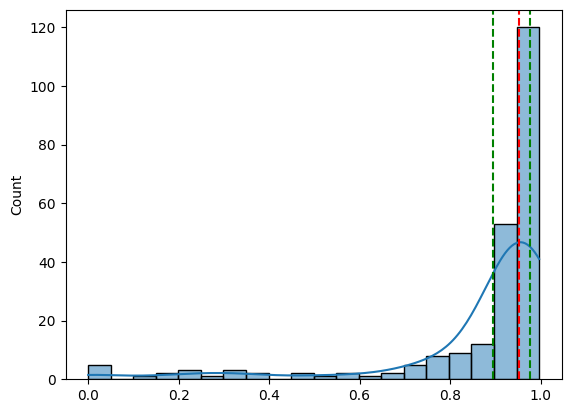

In [125]:
import seaborn as sns
#show stats of ious
ious = np.array(per_image_ious)
#plot the distributiiion of ious
sns.histplot(ious, bins=20, kde=True)
#show the mean and the 75th percentile and the 25th percentile on plot 
plt.axvline(np.median(ious), color='r', linestyle='--')
plt.axvline(np.percentile(ious, 75), color='g', linestyle='--')
plt.axvline(np.percentile(ious, 25), color='g', linestyle='--')
plt.savefig('iou_distribution.png')
plt.show()
#save the plot 



